# 在图块中映射对象面积

在本笔记本中，我们将对图块中的细胞核进行分割并测量它们的面积。然后，我们将再次将生成的面积图保存为zarr文件中的图块。这种策略可用于处理整体上不适合计算机内存的数据。

In [1]:
import zarr
import dask.array as da
import numpy as np
from skimage.io import imread
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from numcodecs import Blosc

出于演示目的，我们使用由德累斯顿工业大学卡尔·古斯塔夫·卡鲁斯大学医院OncoRay的Theresa Suckert提供的数据集。该数据集的许可为[许可证：CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)。我们在这里使用的是经过裁剪并重新保存为8位图像的版本，以便能够随笔记本一起提供。您可以在[在线](https://zenodo.org/record/4276076#.YX1F-55BxaQ)找到完整大小的16位CZI格式图像。

In [2]:
image = imread('../../data/P1_H_C3H_M004_17-cropped.tif')[1]

# 为了测试目的，我们进一步裁剪图像。
# 注释掉下面的行以在整个5000x2000像素上运行
image = image[1000:1500, 1000:1500]

#压缩并将numpy数组转换为zarr数组
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)

# 将图像转换为zarr数组
chunk_size = (100, 100)
zarray = zarr.array(image, chunks=chunk_size, compressor=compressor)

# 将zarr保存到磁盘
zarr_filename = '../../data/P1_H_C3H_M004_17-cropped.zarr'
zarr.convenience.save(zarr_filename, zarray)

## 图块中的对象面积图
Dask为zarr文件格式提供了内置支持。我们可以直接从zarr文件创建dask数组。

In [3]:
zarr_image = da.from_zarr(zarr_filename)
zarr_image

dask.array<from-zarr, shape=(500, 500), dtype=uint8, chunksize=(100, 100), chunktype=numpy.ndarray>

我们可以直接对这个分块数据集应用图像处理。

In [4]:
def area_map(image):
    """
    在二值图像中标记对象并生成像素计数图像。
    """
    print("处理大小为", image.shape, "的图像")
    
    labels = cle.voronoi_otsu_labeling(image, spot_sigma=3.5)
    result = cle.pixel_count_map(labels)
    
    print(result.shape)
    
    return np.asarray(result)

## 测试分块图像处理
我们应该在单个图块上测试我们的面积映射算法。实际上，在真实场景中，图像处理工作流是在单个图块上开发的，例如在这样的笔记本中。一旦我们确定算法有效，就可以将其应用于所有图块。

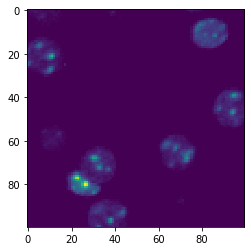

Processing image of size (100, 100)
(100, 100)


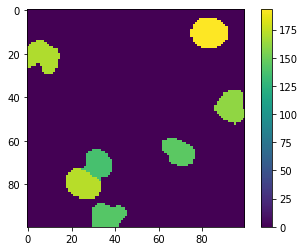

In [5]:
test_image = image[100:200,100:200]

imshow(test_image)

test_result = area_map(test_image)

imshow(test_result, colorbar=True)

## 将分块图像处理应用于基于zarr的数据集

将函数应用于我们的zarr数据集也将产生一个dask数组。

In [6]:
overlap_width = 30

tile_map = da.map_overlap(area_map, zarr_image, depth=overlap_width, boundary=0)

tile_map

Processing image of size (0, 0)
Processing image of size (1, 1)
(1, 1)
Processing image of size (0, 0)


dask.array<_trim, shape=(500, 500), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>

在开始计算之前，我们需要停用pyclesperanto中操作的异步执行。[另请参阅相关问题](https://github.com/clEsperanto/pyclesperanto_prototype/issues/163)。

In [7]:
cle.set_wait_for_kernel_finish(True)

当我们调用将结果保存到磁盘时，处理将在单个图块上进行。

In [8]:
processed_zarr_filename = '../../data/P1_H_C3H_M004_17-processed.zarr'

tile_map.to_zarr(processed_zarr_filename, overwrite=True)

Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size Processing image of size (160, 160)
(160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
(160, 160)
Processing image of size (160, 160)
(160, 160)
(160, 160)
(160, 160)
Processing image of size Processing image of size (160, 160)
(160, 160)
(160, 160)
(160, 160)
(160, 160)
Processing image of size (160, 160)
Processing image of size(160, 160) 
(160, 160)
Processing image of size (160, 160)
(160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
Processing image of size (160, 160)
(160, 160)
Processing image of size (160, 160)
(160, 160)
Processing image of size (160, 160)
(160, 160)
(160, 160)
(160, 160)
(160, 160)Processing image of sizeProcessing image of size(160, 160)
 (160, 160)
 
(160, 1

## 加载zarr
仅出于演示目的，我们将加载基于zarr的分块图像并将其可视化。在处理大数据时，这一步可能无法实现。

In [9]:
zarr_result = da.from_zarr(processed_zarr_filename)
zarr_result

dask.array<from-zarr, shape=(500, 500), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>

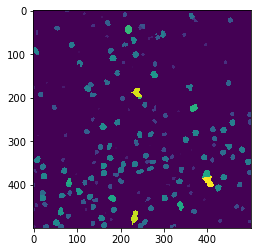

In [10]:
result = zarr_result.compute()

cle.imshow(result)